# "Penney's Game, pt. 3"
> "Failed propositions yield deeper mysteries"

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [probability, simulation, monte-carlo, penneys-game, counterintuitive]
- hide: false
- image: images/pennies_hex.jpg
- search_exclude: false
- metadata_key1: simulation
- metadata_key2: probability

In [1]:
#collapse_output

library(ggplot2)
library(dplyr)
library(tidyr)
library(stringr)
options(repr.plot.width=10, repr.plot.height=6)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




# The Story So Far

We'll begin with a quick recap. 

Penney's Game, loosely, is a game about waiting for particular sequences of coin throws inside a larger sequence of fair coin throws. In our [first foray into the topic](https://aaron-montgomery.github.io/blog/probability/simulation/monte-carlo/penneys-game/counterintuitive/2022/08/05/penneys-game-1.html), we examined head-to-head matchups between sequences of three coins. That is, you and a friend both choose a sequence of three coin flips, and the winner is determined by whose sequence appears first.

The first surprising result about this game -- or at least, surprising if your intuition is anything like mine was -- is that this game is far from fair, and that the win probabilities depend highly on which sequences are chosen.

(NB: I've collapsed the code below since it showed up in a nearly-identical form in a previous post, but you can expand it with the arrow if you're interested.)

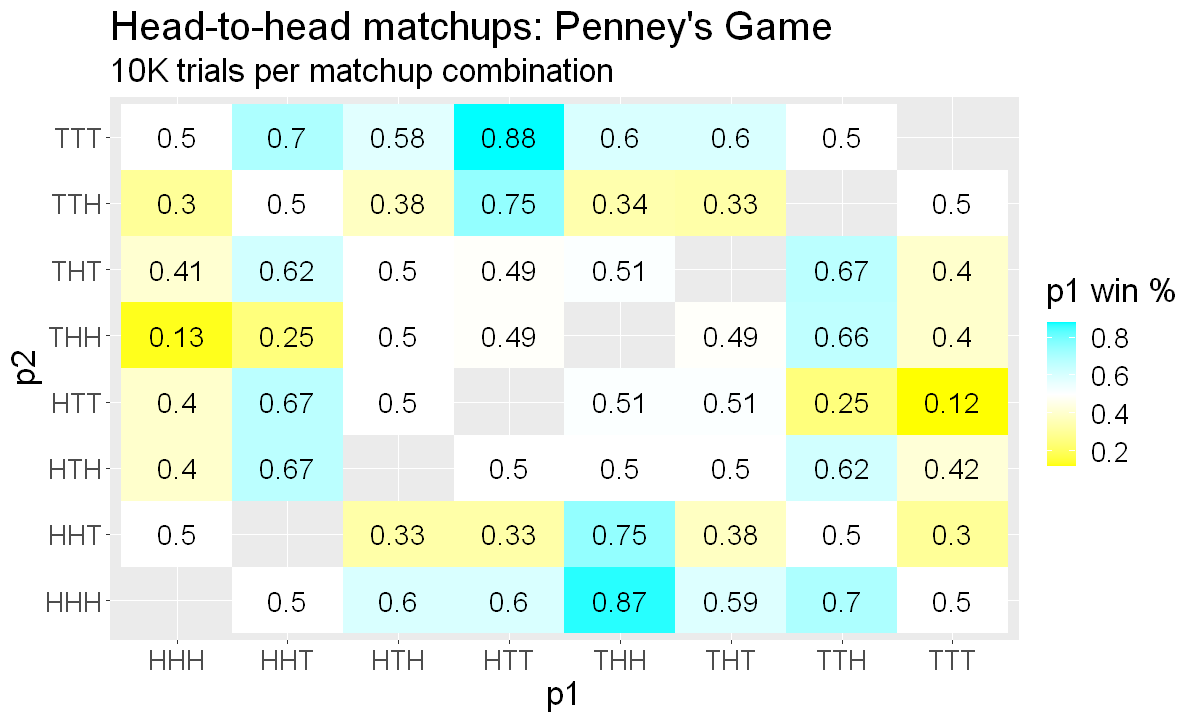

In [13]:
#collapse-hide

#-------------------

# This function will take two strings of coin flips and return the one that occurs
# first in a long sequence of coin flips.

penney <- function(p1, p2){         # p1 and p2 are strings like "HHT", "HTT"
  
  coins <- nchar(p1)                # record how many coins are in the sequences to be compared
    
  p1 <- unlist(str_split(p1, ""))   # split string into vector of length equal to coins
  p2 <- unlist(str_split(p2, ""))
  flips <- sample(c("H", "T"), coins, replace = T) 
    # initialize flips with first coin flips
    
    # on each pass of the while loop, push the first n-1 coins forward in the list,
    # then sample a new coin for the nth one; for instance, HTH becomes TH? where
    # ? is the result of a new coin flip
    
  while(!all(p1 == flips) & !all(p2 == flips)){
    flips[1:(coins - 1)] <- flips[2:coins]
    flips[coins] <- sample(c("H", "T"), 1)
  }
    
  ifelse(all(p1 == flips), 
         paste0(p1, collapse = ""), 
         paste0(p2, collapse = ""))  # output winning sequence
}

#-------------------

# this helper function takes two coin sequences, simulates Penney's game many
# times, and returns the proportion of times the *first* sequence wins
penney_wrapper <- function(p1, p2){
  mean(replicate(1e4, penney(p1, p2)) == p1)
}

# The next function produces a vector of appropriate length enumerating all
# possible sequences of coin flips of that length; for instance, ht_iterator(2)
# will return the vector c("HH", "HT", "TH", "TT"). This works recursively by 
# calling ht_iterator(k-1), duplicating it, and appending each of H and T to 
# one of the duplicates.

ht_iterator <- function(k){
  if(k == 1) {
    return(c("H", "T"))
  } else {
    ht_iterator(k-1) %>%
      rep(each = 2) %>%
      paste0(c("H", "T"))
  } 
}

results <-
  ht_iterator(3) %>%
  combn(2) %>%
  t() %>%
  as.data.frame()
# makes a data frame with all combinations of sequences

names(results) <- c("p1", "p2")

results <- 
  results %>%
  rowwise() %>%
  mutate(p1_wins = penney_wrapper(p1, p2)) %>%
  mutate(p1_wins = round(p1_wins, 2))

results <-
  tibble(
    p1 = results$p2,
    p2 = results$p1,
    p1_wins = 1 - results$p1_wins
  ) %>%
    bind_rows(results)
# since we simulated only half of the matchups, we can just mirror
# the results to flip p1 and p2 rather than resimulating

results %>%
  ggplot(aes(x = p1, y = p2, fill = p1_wins)) +
    geom_tile() +
    geom_text(aes(label = p1_wins), size = 6) +
    scale_fill_gradient2(low = "yellow", mid = "white", 
                         high = "cyan", midpoint = 0.5) +
    labs(title = "Head-to-head matchups: Penney's Game",
         subtitle = "10K trials per matchup combination",
         fill = "p1 win %") +
    theme(text = element_text(size = 20))

Next, we [explored a non-competitive variant of this game](https://aaron-montgomery.github.io/blog/probability/simulation/monte-carlo/penneys-game/counterintuitive/2022/08/10/penneys-game-2.html) in which a player waits for a sequence to appear. Like before, the result that many find counterintuive at first -- and I very much include myself in that group -- is that the expected wait time depends on the sequence chosen.

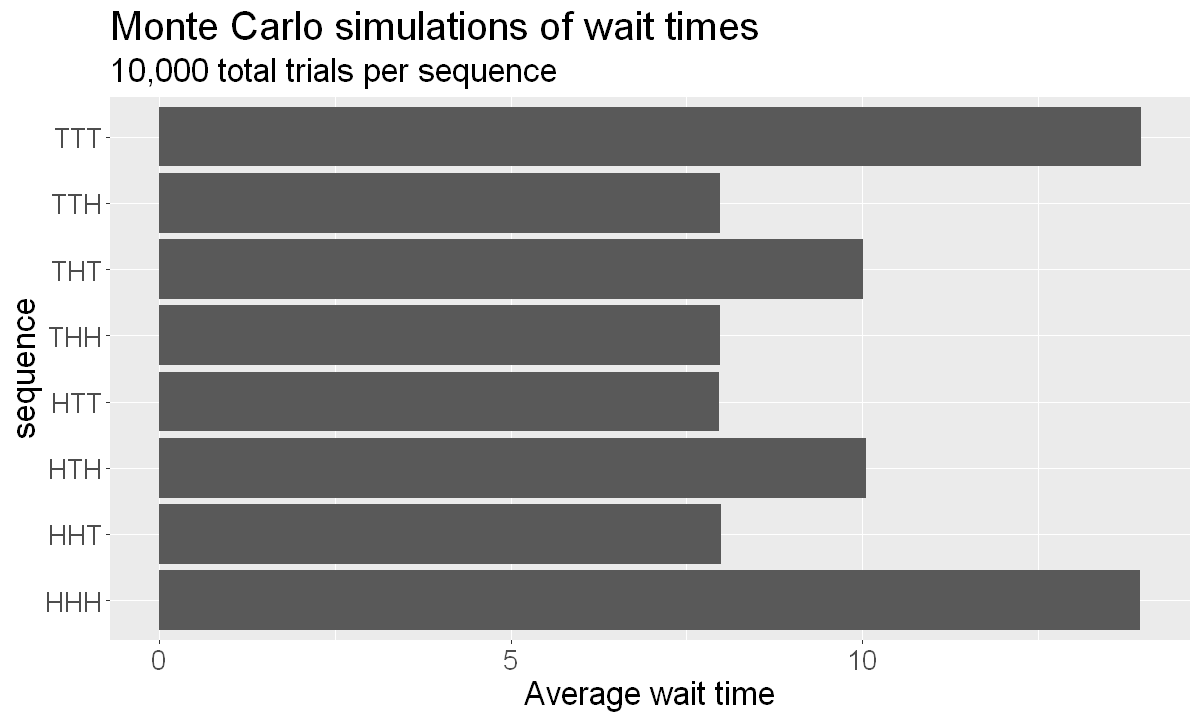

In [14]:
#collapse-hide

penney_wait <- function(p1){
    # p1 is a string like "HHT"
  
  coins <- nchar(p1)                # keep track of how many coins needed
  p1 <- unlist(str_split(p1, ""))   # split string into vector w/ length == coins
    
  flips <- sample(c("H", "T"), coins, replace = T) 
    # initialize flips with first collection of coin flips
    
  num_flips <- coins                # keep track of how many flips have happened
    
    # on each pass of the while loop, push the first n-1 coins forward in the list,
    # then sample a new coin for the nth one; for instance, HTH becomes TH? where
    # "?" is the result of a new coin flip
    
  while(!all(p1 == flips)){
    flips[1:(coins - 1)] <- flips[2:coins]
    flips[coins] <- sample(c("H", "T"), 1)
    num_flips <- num_flips + 1
  }
    
  num_flips                         # output number of flips required to find sequence
}

tibble(sequence = ht_iterator(3)) %>%
  rowwise() %>%
  mutate(avg_wait = mean(replicate(1e4, penney_wait(sequence)))) %>%
  ggplot(aes(x = sequence, y = avg_wait)) +
    geom_bar(stat = "identity") +
    labs(title = "Monte Carlo simulations of wait times",
         subtitle = "10,000 total trials per sequence",
         y = "Average wait time") +
    theme(text = element_text(size = 20)) +
    coord_flip()

Of course, there are good reasons for these phenomena. As with any interesting mathematical question, you can go through the [calculations](https://plus.maths.org/content/os/issue55/features/nishiyama/index) to verify these facts. And yet, in my experience, most people (mathematicians and non-mathematicians alike) crave an intuitive understanding of the problems that lives on a different plane from the calculations and proof. 

When I was first becoming accommodated with Penney's Game, I reconciled the two graphs above by concluding that coin sequences are naturally tiered. From the graph of average wait times, we see a suggested hierarchy:

ranking|sequences
---|---
slow|HHH, TTT
medium|HTH, THT
fast|HHT, HTT, THH, TTH

Indeed, from examining the graph of head-to-head win probabilities, we see that this is indeed the case; all "fast" sequences carry at least a $50\%$ win rate over all "medium" and "slow" sequences, and all "medium" sequences also hold this over the "slow" sequences.

I found this to be quite satisfying, and it led me to wonder: **In Penney's Game, do sequence structures always give rise to this type of hierarchy of both expected values and competitive advantages?**

# The Incorrect Answer

It's probably clear where I'm heading with this, right? This conjecture seemed completely reasonable to me. I assumed that sequences with lower expected wait times would always have competitive advantages (or at least be fair propositions) against sequences with higher expected wait times.

# The Correct Answer

There are no hierarchies here, because Penney's Game is a place where reasonable conjectures go to die. Let's have a look at the expected wait times for the four-coin version of the game:

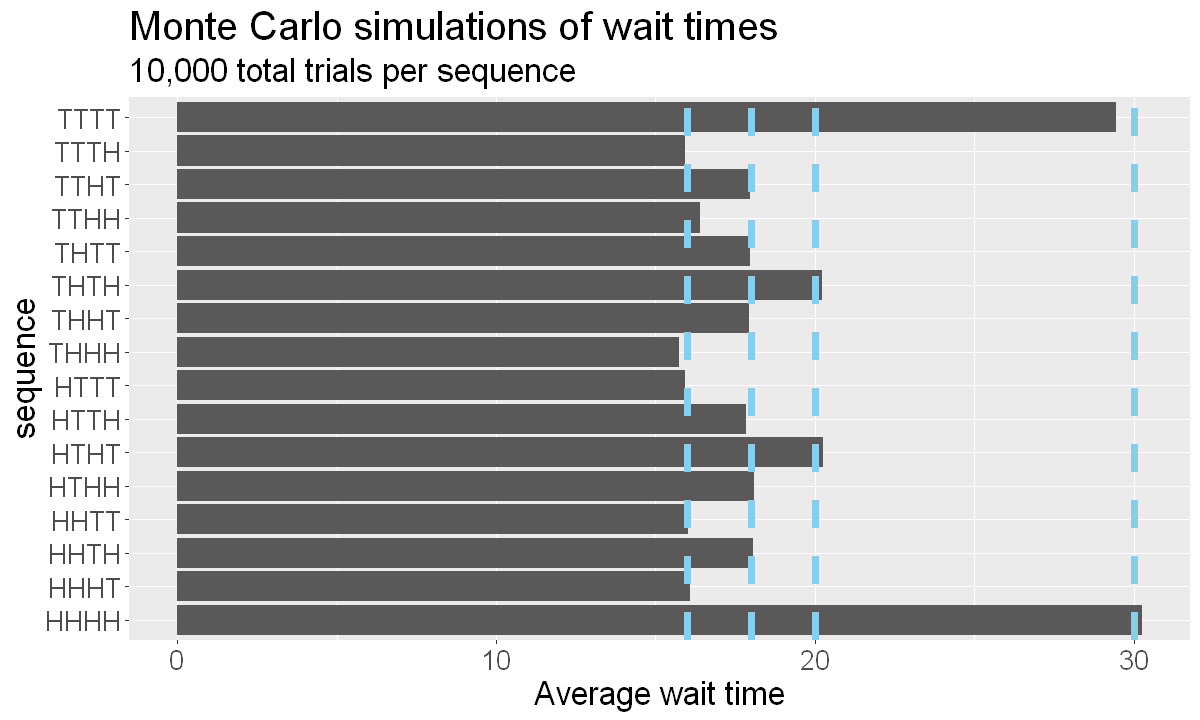

In [15]:
# ht_iterator() appears in the first collapsed code block above
# penney_wait() appears in the second collapsed code block above

tibble(sequence = ht_iterator(4)) %>%
  rowwise() %>%
  mutate(avg_wait = mean(replicate(1e4, penney_wait(sequence)))) %>%
  ggplot(aes(x = sequence, y = avg_wait)) +
    geom_bar(stat = "identity") +
    labs(title = "Monte Carlo simulations of wait times",
         subtitle = "10,000 total trials per sequence",
         y = "Average wait time") +
    theme(text = element_text(size = 20)) +
    coord_flip() +
    geom_hline(yintercept = c(16, 18, 20, 30), lty = 2, lwd = 2, color = "skyblue")

One of the challenges of the Monte Carlo approach is that the bars in the graph fluctuate a bit based on the random simulations, and it can be tough to determine what the exact values are visually. However, by a theorem (one that has not appeared in these notes... *yet*), the true expected wait times of each of these sequences is an even integer. 

That fact is enough to deduce the true expected wait times despite the fluctuations from simulations. Vertical lines on the graph above have been superimposed at positions $x = 16, 18, 20, 30$. That is:

sequences|expected wait time|tier
---|---|---
TTTT, HHHH|30|slowest
HTHT, THTH|20|med. slow
TTHT, THTT, THHT, HTTH, HTHH, HHTH|18|med. fast
TTTH, TTHH, THHH, HTTT, HHTT, HHHT|16|fastest

If a hierarchy exists, this is what it would have to be. 

Next, let's pit all the "fastest" group coins against the "med. fast" group coins competitively. There's nothing special about this particular choice of tiers to compare, other than that it gives us lots of combinations to pit against each other.

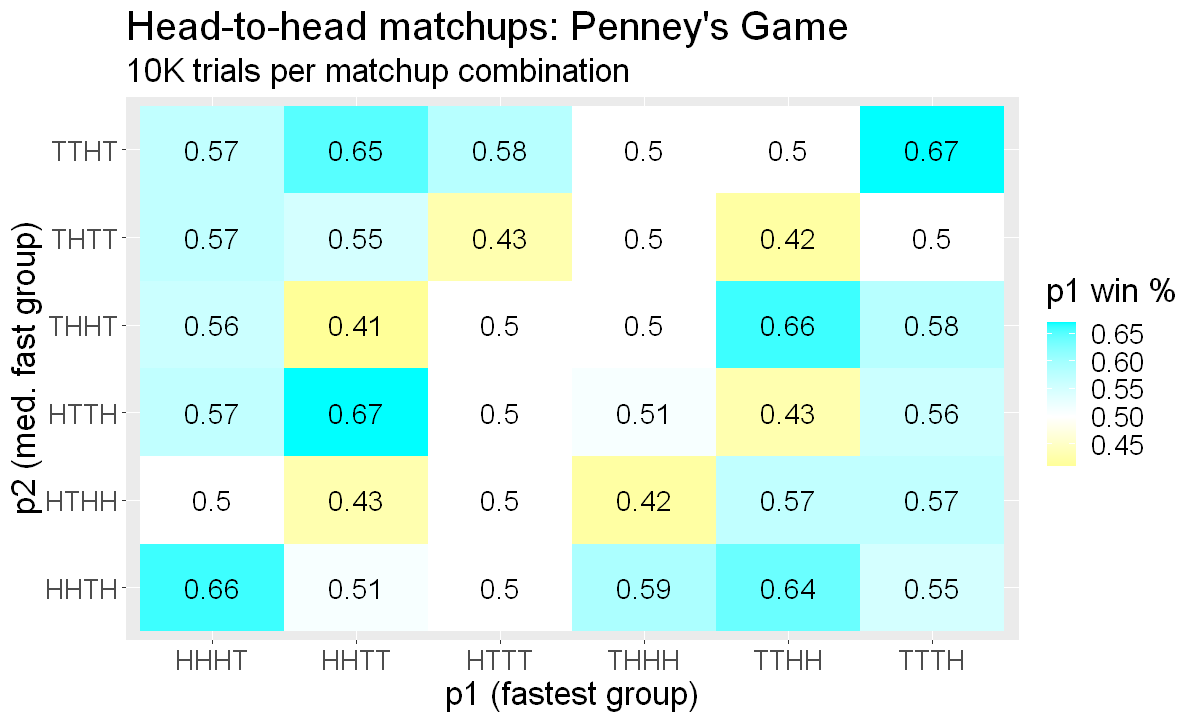

In [22]:
# elements below defined in the collapsed code block above:
#  penney_wrapper()

four_coin_results <- 
  expand.grid(c("TTTH", "TTHH", "THHH", "HTTT", "HHTT", "HHHT"),
              c("TTHT", "THTT", "THHT", "HTTH", "HTHH", "HHTH"),
             stringsAsFactors = FALSE) %>%
    as.data.frame() %>%
    rename("p1" = "Var1", "p2" = "Var2") %>% 
    mutate_all(as.character())

four_coin_results <-
  four_coin_results %>%
  rowwise() %>%
  mutate(p1_wins = penney_wrapper(p1, p2)) %>%
  mutate(p1_wins = round(p1_wins, 2))

four_coin_results %>%
  ggplot(aes(x = p1, y = p2, fill = p1_wins)) +
    geom_tile() +
    geom_text(aes(label = p1_wins), size = 6) +
    scale_fill_gradient2(low = "yellow", mid = "white", 
                         high = "cyan", midpoint = 0.5) +
    labs(title = "Head-to-head matchups: Penney's Game",
         subtitle = "10K trials per matchup combination",
         fill = "p1 win %",
         x = "p1 (fastest group)",
         y = "p2 (med. fast group)") +
    theme(text = element_text(size = 20))


A few coins in the "fastest" group do indeed dominate those in the "med. fast" group -- but not all of them. HHTT, HTTT, THHH, and TTTH all have a competitive disadvantage against at least one coin from the allegedly lower tier.

Goodbye, Reasonable Conjecture... we hardly knew ye.

# The Big Lesson

The most obvious lesson is that Penney's Game is weird -- which, sure. That's at least the third time we've learned that particular lesson. More generally, we might use this as a reminder that probability is home to **lots** of counterintuitive results.

But I think the most important part of this story comes back to the idea of a [mathematical laboratory](https://aaron-montgomery.github.io/blog/probability/simulation/monte-carlo/eulers-number/counterintuitive/2022/07/27/ordered-objects.html). The Penney's Game saga so far naturally invites several questions for further exploration, such as:
* If I know the sequence chosen by my opponent, how do I build the sequence with the best advantage over it?
* Can a shorter sequence (like TTT) ever have a faster wait time than a longer sequence (like HTHH)? 
  * We've actually seen that the answer is no for sequences of length 3 and 4, but what about longer sequences?
* Is there any kind of pattern in the expected wait times as the sequence lengths increase? 
* Can a longer sequence ever have a direct head-to-head competitive advantage over a shorter sequence?

Francis Su writes in his wonderful book *Mathematics for Human Flourishing* about what it means to be a mathematical explorer:

> Exploration cultivates an *expectation of enchantment.* Explorers are excited by the thrill of finding the unexpected, especially things weird and wonderful. It's why hikes through unfamiliar terrain entice us, why unexplored caves beckon to us, why the strange creatures of the deep-sea ocean floor fascinate us -- what else may be lurking down there? There's similar enchantment to be found in the zoo of strange discoveries in math.

Anyone with any level of expertise in probability (including none), and the ability to write code, can engage in investigations like those above. Thanks to Monte Carlo simulations, the joy of exploration in Penney's Game can suddenly become *accessible* as a new class of explorers are invited to broaden the scope of who can partake in the beauty of mathematics. This is the way that Monte Carlo simulations can function as a mathematical laboratory; they can be used as a vessel for exploration and discovery.

If I could change one thing about my own experience working toward my PhD in Mathematics, I would have embraced Monte Carlo simulations much earlier in my career. I was able to construct them as a graduate student, but since I had never considered them in a particularly structured way, I tended not to reach for that tool when working on problems. I wish I had done that, though; I think engaging more in simulations early in my career could have sharpened my intuition, confirmed difficult theoretical calculations, and maybe even suggested new theorems to try to prove. 


# To Be Continued...

And yet, Monte Carlo simulations are also limited in scope. The ability of simulations to *suggest* conjectures is profound; their ability to *prove* those conjectures is flimsy at best. They typically fall short of showing *why* things are the way they are.

In Penney's Game, some of the *why* questions might include:

* [Why do some sequences have competitive advantages against each other?](https://aaron-montgomery.github.io/blog/probability/simulation/monte-carlo/penneys-game/counterintuitive/2022/08/05/penneys-game-1.html)
* What are the structural considerations of sequences that inform their expected wait times or competitive advantages?
* What are the exact win probabilities between sequences that are reflected as mere shadows in Monte Carlo simulations above?
* [Why can different sequences have different expected wait times?](https://aaron-montgomery.github.io/blog/probability/simulation/monte-carlo/penneys-game/counterintuitive/2022/08/10/penneys-game-2.html)
* Why are the expected wait times of any sequence always even integers?

Questions like these require good old-fashioned mathematical arguments. Those are up next.